In [12]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys
sys.path.append('../..')
import pandas as pd
import seaborn as sns
import Model.input_pipeline
from Model.results import get_df, get_stats, final_plot

# Helper functions

In [13]:
def plus_encode_data(data):
    data = tf.reshape(data, shape=(data.shape[0], -1))
    mean_data = tf.reduce_mean(data, axis=1, keepdims=True)
    need_change = tf.cast(mean_data < 0.5, data.dtype)
    data = data * (1 - 2 * need_change) + need_change
    data = tf.reshape(data, shape=(-1, 32, 32, 1))
    return data   

def sample(num, generator, noise_dim=100):
    random_vector_for_generation = tf.random.normal([num, 1, 1, noise_dim])
    return generator(random_vector_for_generation)

def random_swap(data):
    data = tf.reshape(data, shape = (data.shape[0], -1))
    swap_mask = 2 * (np.random.random(size = (data.shape[0], 1)) > 0.5) - 1
    data = tf.multiply(data, swap_mask)
    data = tf.reshape(data, shape = (-1, 32, 32, 1))
    return data

def load_model_at_T(t, folder):
    generator = tf.keras.models.load_model(f"results/{folder}/{t:.1f}/generator")
    return generator

## Models dictionary

In [3]:
folder = "gan_v2"
temps = np.arange(2.0, 3.1, 0.1)
data_list = []

# Compare with monte carlo

## Sampled vs Rounded

In [9]:
model = load_model_at_T(2.0, folder)
data = sample(1000, model)
data_sampled = 2 * np.random.binomial(1, data) - 1
data_rounded = 2 * np.round(data) - 1
data_raw = 2 * np.array(data) - 1
df_sampled = get_df(data_sampled)
df_rounded = get_df(data_rounded)
df_raw = get_df(data_raw)

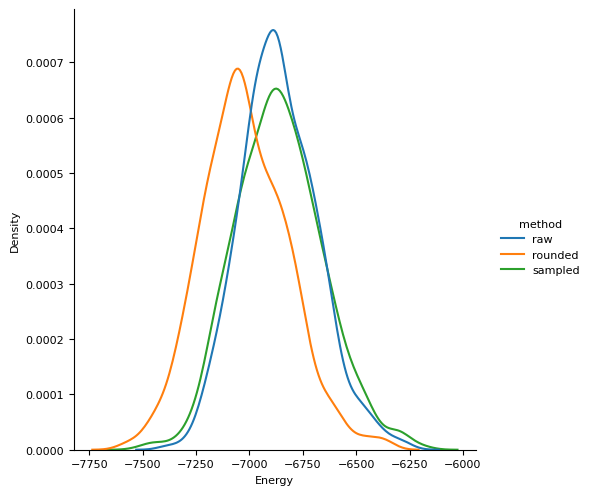

In [11]:
df_raw['method'] = 'raw'
df_rounded['method'] = 'rounded'
df_sampled['method'] = 'sampled'
df = pd.concat([df_raw, df_rounded, df_sampled])
sns.displot(df, x='Energy', hue='method', kind='kde')

## Data Generated

In [10]:
with tf.device('CPU:0'):
    for temp in temps:
        # Monte Carlo
        trainset_path = f"../../GetData/Python/Data/Data{temp:.2}.tfrecord"
        batch_size = 100
        train_set = Model.input_pipeline.dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)
        model = load_model_at_T(temp, folder)
        
        sample_list = []
        mc_list = []
        for batch in train_set:
            mc_list.append(batch)
            sample_list.append(sample(batch_size, model))
        
        data_mc = 2 * np.concatenate(mc_list, axis=0) - 1
        spin_sample =  2 * np.round(np.concatenate(sample_list, axis=0)) - 1
        spin_sample = random_swap(spin_sample)

        df_monte_carlo = get_df(data_mc)
        mc_stats = get_stats(df_monte_carlo, temp)
        mc_stats.extend((temp, "Monte Carlo"))
    
        df_sampled = get_df(spin_sample)
        sample_stats = get_stats(df_sampled, temp)
        sample_stats.extend((temp, "GAN"))
    
        data_list.append(mc_stats)
        data_list.append(sample_stats)

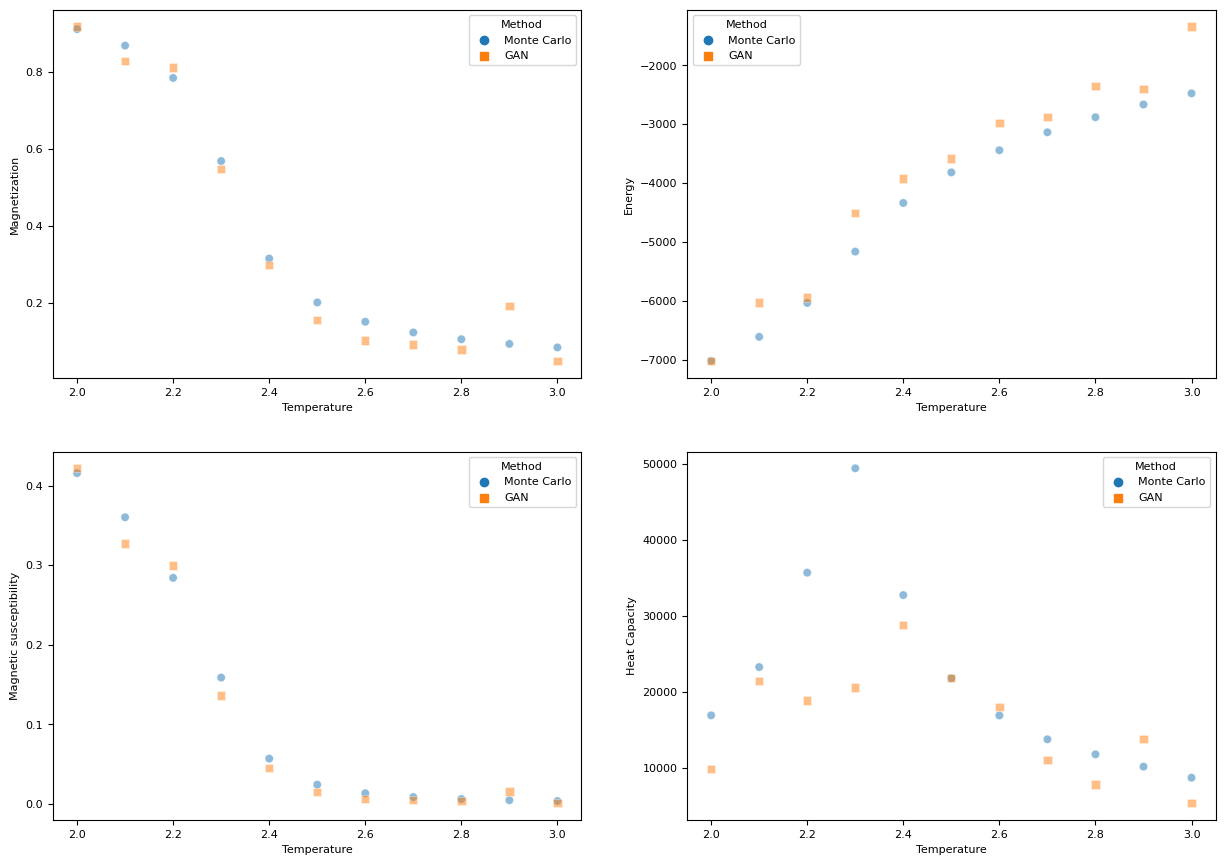

In [11]:
final_plot(data_list)
plt.savefig("final_plot.svg")

## Examples

In [19]:
models = { temp: load_model_at_T(temp, folder) for temp in temps }
titles = [f"Temperature: {temp:.1f}" for temp in temps]

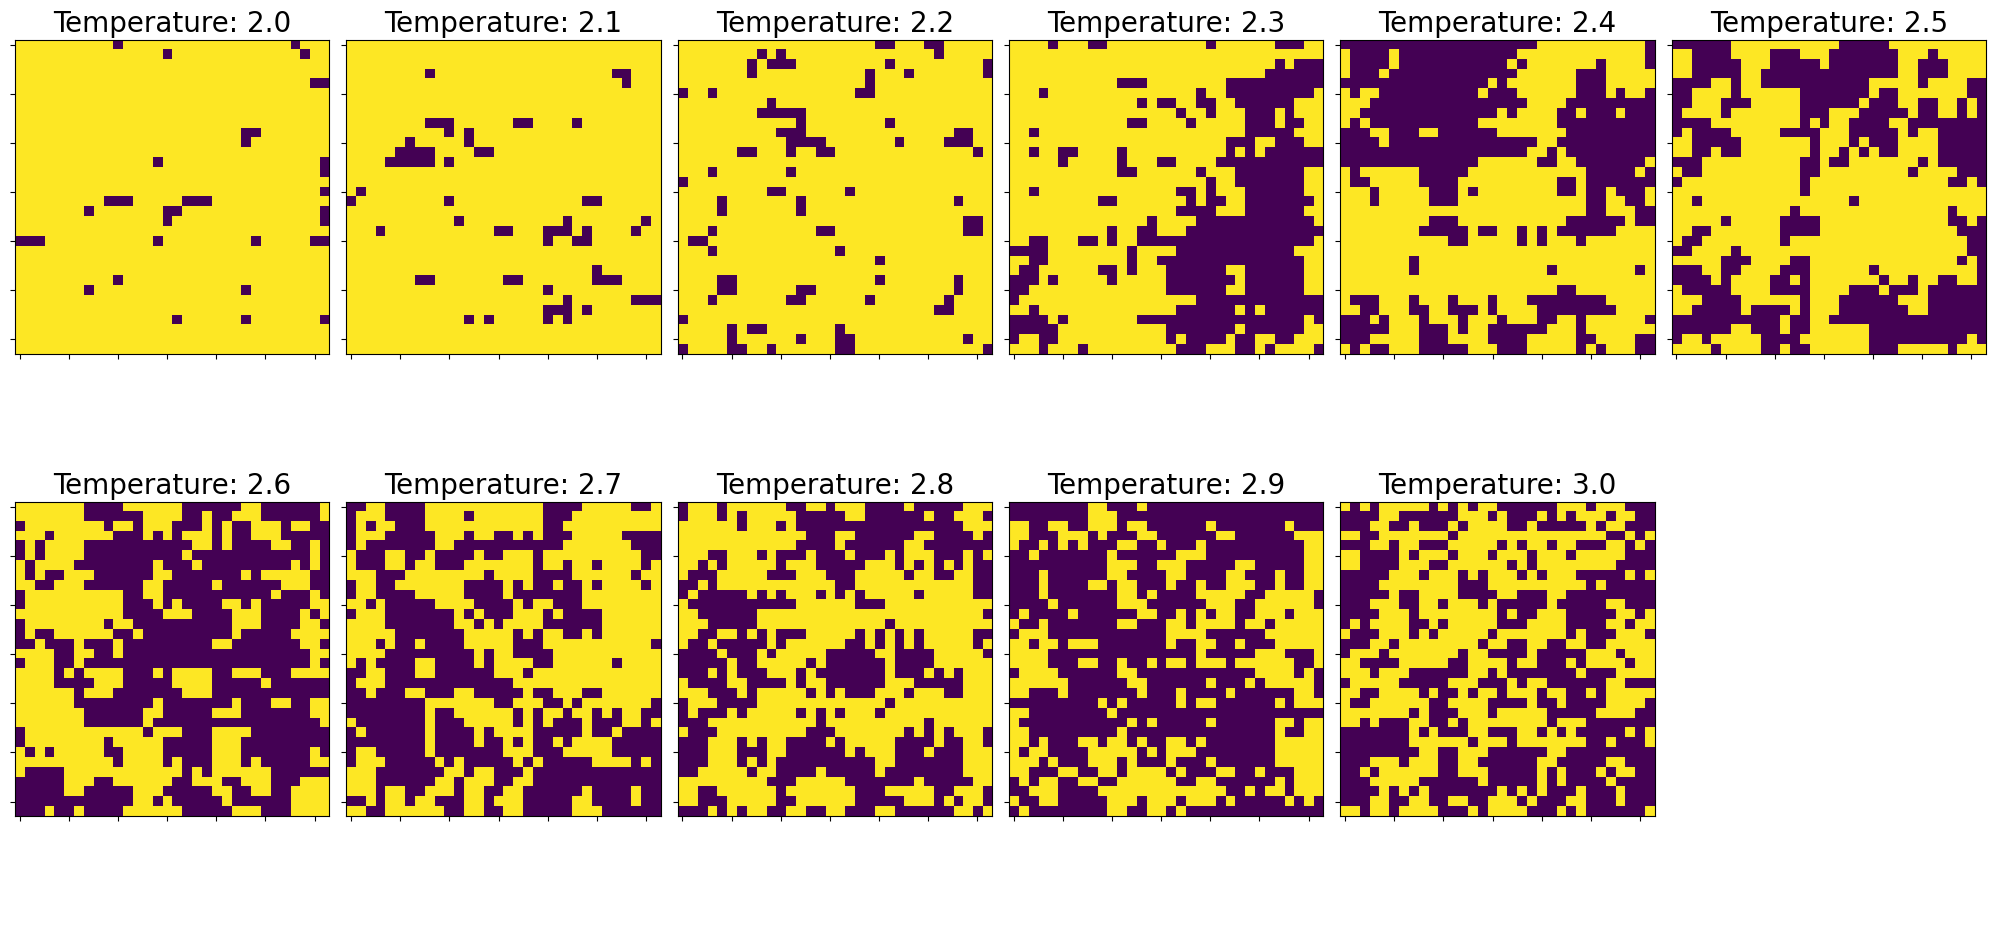

In [29]:
import math

# Calculate the number of columns needed
ncols = math.ceil(len(temps) / 2)

fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(20, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(temps):  # Check if we have a model for this subplot
        ax.set_title(titles[i], fontsize=20)
        predictions = sample(5, models[temps[i]])
        ax.yaxis.set_ticklabels([])
        ax.xaxis.set_ticklabels([])
        spins = predictions[0, :, :] > 0.5  # Use the first prediction for each temperature
        ax.imshow(spins, vmin=0, vmax=1)
    else:  # If we don't have a model, hide the subplot
        ax.axis('off')

plt.subplots_adjust(hspace=0.15)  # Adjust the height of the padding between subplots
plt.tight_layout()
plt.savefig("example.svg")
plt.savefig("example.png")